In [1]:
import numpy as np 
import sys, os
sys.path.append('../Netket/')
import netket as nk
from jax import numpy as jnp
import itertools
from scipy.special import comb
from jax import jit, vmap
import jax
import matplotlib.pyplot as plt 
from cluster_expansion import fwht, fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial

/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import functools, importlib
# _orig_lru_cache = functools.lru_cache
# functools.lru_cache = lambda *args, **kwargs: (lambda f: f)   # no-op decorator

# import cluster_expansion
# importlib.reload(cluster_expansion)   # ensures module is loaded with the no-op

# # restore original decorator so other code behaves normally
# functools.lru_cache = _orig_lru_cache

In [3]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'

h5_files_opt = [os.path.join(f"{data_root}/data/data_optimal_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_optimal_basis_rbm') if f.endswith('.h5')]
df_opt = analysis.load_outputs_to_dataframe(h5_files_opt, load_eigenstates=False)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))


230


In [5]:
n_sites_test = 16
hilb_test = nk.hilbert.Spin(0.5, n_sites_test)
compr_idx_list = sorted(np.array(list(set(np.logspace(1, 16, 50, base=2, dtype=int)))))  


idx = 10
# idx = df_opt.idx.values[142]
row = df_opt[df_opt.idx == idx].iloc[0]
psi_test_exact = row['psi_0']
psi_test_RBM = row['psi']
cluster_coeffs_test_exact = fwht_coeffs_in_cluster_col_order(np.log(psi_test_exact), hilb_test)
cluster_coeffs_test_RBM = fwht_coeffs_in_cluster_col_order(np.log(psi_test_RBM), hilb_test)

prepare_fwht_meta_cached(hilb_test)  # fill cache (fast)

infidels_exact_opt = [infidelity(compress_and_reconstruct_cached(cluster_coeffs_test_exact, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]
infidels_RBM_opt = [infidelity(compress_and_reconstruct_cached(cluster_coeffs_test_RBM, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]

# mask = _get_topk_indices_jit(cluster_coeffs_test, 5)
# mask, jnp.abs(cluster_coeffs_test[mask])

In [6]:
# Mark masks_tuple, inv_perm_tuple and n as static to avoid hashing traced objects
@partial(jit, static_argnums=(1, 2, 3))
def MOD_reconstruct_from_trunc_jit(trunc, masks_tuple, inv_perm_tuple, n):
    # convert static tuples to jnp arrays (these will be constants in compiled function)
    masks_jnp = jnp.array(masks_tuple, dtype=jnp.int32)
    inv_perm_jnp = jnp.array(inv_perm_tuple, dtype=jnp.int32)

    coeffs_by_index = jnp.zeros(n, dtype=jnp.complex128)
    coeffs_by_index = coeffs_by_index.at[masks_jnp].set(trunc)
    logpsi_by_index = fwht(coeffs_by_index)
    logpsi = logpsi_by_index[inv_perm_jnp]
    psi = logpsi
    return psi


# Mark num_kept, masks_tuple, inv_perm_tuple and n as static arguments
@partial(jit, static_argnums=(1, 2, 3, 4))
def MODcompress_and_reconstruct_cached_jit(full_coeffs, num_kept, masks_tuple, inv_perm_tuple, n):
    # num_kept is static (Python int); pass it to the static _get_topk_indices_jit
    top_idx = _get_topk_indices_jit(full_coeffs, num_kept)
    trunc = jnp.zeros_like(full_coeffs).at[top_idx].set(full_coeffs[top_idx])
    psi = MOD_reconstruct_from_trunc_jit(trunc, masks_tuple, inv_perm_tuple, n)
    return psi


# Convenience Python wrapper that uses the cache and returns a NumPy array
def MODcompress_and_reconstruct_cached(full_coeffs, num_kept, hilbert):
    masks_tuple, inv_perm_tuple, n = prepare_fwht_meta_cached(hilbert)
    full_coeffs_jnp = jnp.array(full_coeffs, dtype=jnp.complex128)
    # ensure num_kept is a Python int when passed
    psi_jnp = MODcompress_and_reconstruct_cached_jit(full_coeffs_jnp, int(num_kept), masks_tuple, inv_perm_tuple, n)
    return np.array(jax.device_get(psi_jnp))

In [7]:
MODcluster_coeffs_test_exact = fwht_coeffs_in_cluster_col_order(psi_test_exact, hilb_test)
MODcluster_coeffs_test_RBM = fwht_coeffs_in_cluster_col_order(psi_test_RBM, hilb_test)
MODinfidels_exact_opt = [infidelity(MODcompress_and_reconstruct_cached(MODcluster_coeffs_test_exact, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]
MODinfidels_RBM_opt = [infidelity(MODcompress_and_reconstruct_cached(MODcluster_coeffs_test_RBM, compr_idx, hilb_test), psi_test_exact) 
           for compr_idx in compr_idx_list]

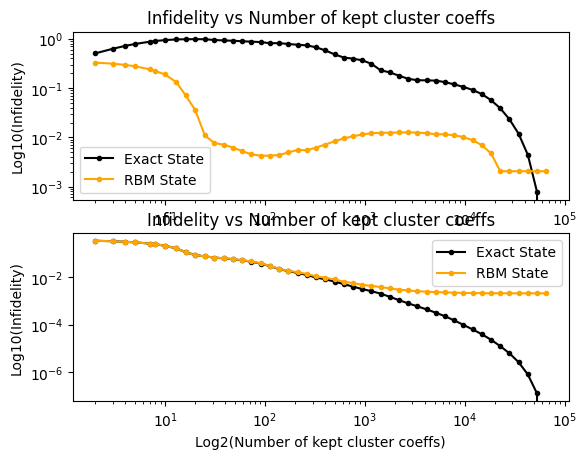

In [8]:
fig, ax = plt.subplots(2)
ax[0].plot(compr_idx_list, (infidels_exact_opt), '.-', label='Exact State', color='black')
ax[0].plot((compr_idx_list), (infidels_RBM_opt), '.-', label='RBM State', color='orange')
ax[0].set_xlabel('Log2(Number of kept cluster coeffs)')
ax[0].set_ylabel('Log10(Infidelity)')
ax[0].set_title('Infidelity vs Number of kept cluster coeffs')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')
# ax[0].axvline(get_N_params(np.log2(len(row.psi)), row.alpha), color='red', linestyle='--', label='RBM Params (alpha=4)')

ax[1].plot(compr_idx_list, (MODinfidels_exact_opt), '.-', label='Exact State', color='black')
ax[1].plot((compr_idx_list), (MODinfidels_RBM_opt), '.-', label='RBM State', color='orange')
ax[1].set_xlabel('Log2(Number of kept cluster coeffs)')
ax[1].set_ylabel('Log10(Infidelity)')
ax[1].set_title('Infidelity vs Number of kept cluster coeffs')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xscale('log')


plt.show()

In [9]:
def get_N_params(Nsites,alpha):
    Nhidden = int(alpha * Nsites)
    Nparams = Nsites * Nhidden + Nsites + Nhidden
    return Nparams

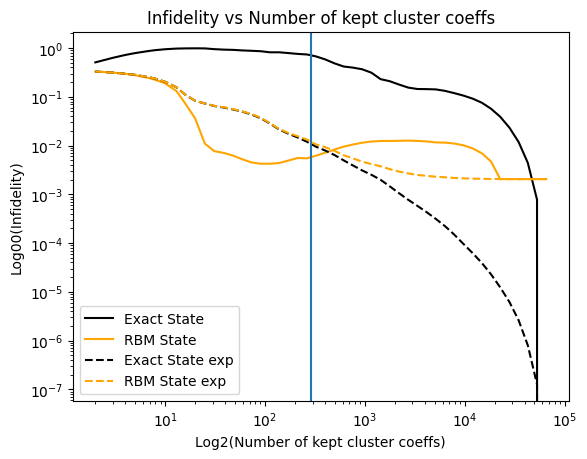

In [10]:
fig, ax = plt.subplots(1)
ax = (ax,)
ax[0].plot(compr_idx_list, (infidels_exact_opt), label='Exact State', color='black')
ax[0].plot((compr_idx_list), (infidels_RBM_opt), label='RBM State', color='orange')
ax[0].set_xlabel('Log2(Number of kept cluster coeffs)')
ax[0].set_ylabel('Log10(Infidelity)')
ax[0].set_title('Infidelity vs Number of kept cluster coeffs')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
# ax[0].axvline(get_N_params(np.log2(len(row.psi)), row.alpha), color='red', linestyle='--', label='RBM Params (alpha=4)')

ax[0].plot(compr_idx_list, (MODinfidels_exact_opt), '--', label='Exact State exp', color='black')
ax[0].plot((compr_idx_list), (MODinfidels_RBM_opt), '--', label='RBM State exp', color='orange')
ax[0].set_xlabel('Log2(Number of kept cluster coeffs)')
ax[0].set_ylabel('Log00(Infidelity)')
ax[0].set_title('Infidelity vs Number of kept cluster coeffs')
ax[0].legend()

ax[0].axvline(get_N_params(16,1))


plt.show()

In [13]:
which_cluster_exact = _get_topk_indices_jit(coefs=cluster_coeffs_test_exact, k=10)
which_cluster_rbm = _get_topk_indices_jit(coefs=cluster_coeffs_test_RBM, k=10)
which_hadamaard_exact = _get_topk_indices_jit(coefs=MODcluster_coeffs_test_exact, k=10)
which_hadamaard_rbm = _get_topk_indices_jit(coefs=MODcluster_coeffs_test_RBM, k=10)

print('cluster_exact: ', which_cluster_exact)
print('cluster_rbm: ', which_cluster_rbm)
print('hadamaard_exact: ', which_hadamaard_exact)
print('hadamaard_rbm: ', which_hadamaard_rbm)


cluster_exact:  [  0 130  35  49 119 125  62 112  20  28]
cluster_rbm:  [  0  57  74  28  95 130  62  35  20  49]
hadamaard_exact:  [  0 104  43  57  70  74  85  95  28  20]
hadamaard_rbm:  [  0  57  74  28  95  49  62  35  20 104]


In [14]:
row.head()

psi        [(-0.0063525685+0.0009865653j), (-0.0054944525...
psi_0      [(0.0035906035429349847+0.004957791929098635j)...
Delta_E                                              0.00075
E_exact                                           -65.778225
E_var                                             -65.728865
Name: 206, dtype: object

In [47]:
sys.path.append('../Netket')
sys.path.append('../python')
import parseCouplings
from rotation import get_U_single, apply_local_rotation_to_state, get_rotation_objective
from optimization import *
import h5py
input_file = "../python/couplings69.csv"
Jijs, hs, bondss = parseCouplings.parseCouplings(input_file)
H_idx = idx
alpha_opt , beta_opt, gamma_opt = row['alpha_opt'], row['beta_opt'], row['gamma_opt']
H_rot = construct_hamiltonian_bonds_unitary(Jijs[H_idx], hs[H_idx], bondss[H_idx], 
                                            get_U_single(alpha_opt, beta_opt, gamma_opt))


Jijs[H_idx][0], Jijs[H_idx][-1], hs[H_idx][0]

coups_file = "idx10couplings.h5"
# f = h5py.File(coups_file,'w')
df_dump = pd.DataFrame({
    'Jx': [Jijs[H_idx][0]],
    'Jy': [Jijs[H_idx][-1]], 
    'h': [hs[H_idx][0]],
    'alpha_opt': [alpha_opt],
    'beta_opt': [beta_opt],
    'gamma_opt': [gamma_opt]
})

with h5py.File(coups_file, 'w') as f:
    f.create_dataset('Jx', data=Jijs[H_idx][0])
    f.create_dataset('Jy', data=Jijs[H_idx][-1])
    f.create_dataset('h', data=hs[H_idx][0])
    f.create_dataset('alpha_opt', data=alpha_opt)
    f.create_dataset('beta_opt', data=beta_opt)
    f.create_dataset('gamma_opt', data=gamma_opt)


